## Team members: Shahbab Ahmed, Amirul Miah, Tanbirul Miah

Link to API: https://www.alphavantage.co/documentation/#

Link to CSV files: https://www.kaggle.com/alvarob96/spanish-stocks-historical-data?select=indra.csv

## API Stock Data

### get_monthly_data 

This function takes in a list of stock symbols and returns a dictionary of monthly stock data for those specified stocks. It uses the function create_request_url to pass in the symbols and create the url that you must send the request to. After the request is made, what's returned is stock data in json format. We use json.loads to parse the json data into a readable python dictionary. Then we iterate over that dictionary in order to grab the data we want (high price, low price, etc.) and put all of that data into a new dictionary that is structured as such: key = stock symbols, values = list of tuples where elements within each tuple contains data. 

In [40]:
import json
import requests
from urllib.request import urlopen, Request
import random
import pandas as pd

# Use GC1SJ3IS4Y5SV6PJ
#API_KEY = input("Please Enter a Valid API Key for Alpha Vantage: ")
API_KEY ="GC1SJ3IS4Y5SV6PJ"
#stock_symbols = input("Please enter the symbol for the stocks you want to fetch data for. Seperate multiple stocks using comma.")

#create the URL for sending a request to Alpha Vantage
def create_request_url(symbol):
    return "https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY_ADJUSTED&symbol="+ symbol + "&" + "apikey=" + API_KEY

#pass in a list of stock symbols, grab and load the data into a dictionary and return it
def get_monthly_data(symbols):

    new_dict = {}
    
    #creating request urls
    for symbol in symbols:
        request_url = create_request_url(symbol)
        print("Trying to fetch data for " + symbol)
        
        #sending request to API and getting the data as a json
        response = urlopen(request_url)
        data = json.load(response)
        
        #iterate over returned dict and create a new dict with only the data we want
        if "Monthly Adjusted Time Series" in data.keys():
            for i in data["Monthly Adjusted Time Series"]:
                
                
                high_price = data["Monthly Adjusted Time Series"][i]["2. high"]
                low_price = data["Monthly Adjusted Time Series"][i]["3. low"]
                open_price = data["Monthly Adjusted Time Series"][i]["1. open"]
                close_price = data["Monthly Adjusted Time Series"][i]["4. close"]
                volume = data["Monthly Adjusted Time Series"][i]["6. volume"]
                date = i
                    
                if symbol in new_dict:
                        
                    new_dict[symbol].append((high_price, low_price, open_price, close_price, volume, date))
                    
                else:
                        
                    new_dict[symbol] = [(high_price, low_price, open_price, close_price, volume, date)]
    print("Finished fetching data")
    return new_dict

# MSFT,INTC,CSCO,AMGN,GOOG
# Use GC1SJ3IS4Y5SV6PJ
fetched_data = get_monthly_data(["MSFT","INTC","CSCO","AMGN","QCOM"])

Trying to fetch data for MSFT
Trying to fetch data for INTC
Trying to fetch data for CSCO
Trying to fetch data for AMGN
Trying to fetch data for QCOM
Finished fetching data


### create_sql_db

This function takes in a dictionary (specifically the dictionary returned by get_monthly_data) and returns a dataframe. We create an SQL database called "stocks" with the same columns as what the values in the dictionary are, in addition to the column "market" and "year". Then we execute a loop that iterates over the dictionary, each time inserting the values in their respective columns in the database. "market" was set to be "US" for later analysis and "year" was also set for filtering. After all the data has been inserted into the database, we used a select query alongside pd.read_sql in order to filter out all years outside of our 2005-2015 range and put the result into a dataframe, which is returned after we set the date into a datetime index.

In [41]:
def create_sql_db(fetched_data):
    
    print("Trying to create SQL Table using fetched data")
    
    import psycopg2
    host="localhost"
    dbname="si330"
    user="jovyan"
    password="si330studentuser"
    conn = psycopg2.connect(host=host, dbname=dbname, user=user, password=password)
    conn.autocommit = True
    
    
    
    try:
        cursor = conn.cursor()
        cursor.execute("drop table if exists stocks")
        cursor.execute('''
            create table stocks (
            symbol varchar(5),
            high_price float,
            low_price float,
            open_price float,
            close_price float,
            volume BIGINT,
            market varchar(255),
            date timestamp,
            year integer
        );
        ''')
    
    except psycopg2.DatabaseError as error:
        print(error)
        
    for data in fetched_data:
        for k in fetched_data[data]:
            try:
                
            
                cursor = conn.cursor()
                cursor.execute("insert into stocks (symbol, high_price, low_price, open_price, close_price, volume, market, date, year) values (%s, %s, %s, %s, %s, %s, %s, %s, %s)", 
                               (data, k[0], k[1], k[2], k[3], k[4], "US", k[5], int(k[5].split("-")[0])))


            except psycopg2.DatabaseError as error:
                print(error)
                
    df = pd.read_sql('SELECT * from stocks where year between 2005 and 2015;', conn)
    df = df.drop(["year"], axis=1)
    df['date'] = pd.to_datetime(df['date'])
    df.date = pd.to_datetime(df.date)
    
    print("Finished creating SQL table")
    return df

df = create_sql_db(fetched_data)


Trying to create SQL Table using fetched data
Finished creating SQL table


## CSV Stock Data

### read_csv_files

read_csv_files reads in 5 csv files (each containing stock data for an individual stock). It sets the symbols in each dataframes for the respective stock. Then we concatenate all 5 dataframes, create a new column called "Market" with the value "Spanish", and filter out all dates outside of our 2005-2015 range.

clean_df is used to match the dataframe returned by read_csv_files with the dataframe returned by create_sql_db. We first renamed all of the columns so they match the column names for the api dataframe, set the date as a datetime index, then resampled the date to monthly since the data for all of the csv files were in daily format. 


In [42]:
import pandas as pd
import numpy as np

def read_csv_files():
    df = pd.read_csv('bbva.csv')
    df['Symbol'] = 'BBVA'

    df2 = pd.read_csv('iberdrola.csv')
    df2['Symbol'] = 'IBE'

    df3 = pd.read_csv('inditex.csv')
    df3['Symbol'] = 'ITX'

    df4 = pd.read_csv('santander.csv')
    df4['Symbol'] = 'SAN'

    df5 = pd.read_csv('telefnica.csv')
    df5['Symbol'] = 'TED'

    dataframes = [df, df2, df3, df4, df5]
    ndf = pd.concat(dataframes)
    ndf['Market'] = 'Spanish'
   
    ndf = ndf[(ndf['Date'] >= '2005') & (ndf['Date'] < '2016')]
   
    return ndf

def clean_df():
    
    df = read_csv_files()
    df = df.rename(columns={"Date": "date", "Close": "close_price", "High": "high_price", "Low": "low_price", "Open": "open_price", "Volume": "volume", "Symbol": "symbol", "Market": "market"})
    df = df[['symbol', "high_price", 'low_price', 'open_price', 'close_price', "volume", "market", "date"]]
    df["high_price"] = df["high_price"] * 1.4389
    df["close_price"] = df["close_price"] * 1.4389
    df["low_price"] = df["low_price"] * 1.4389
    df["open_price"] = df["open_price"] * 1.4389

    df['date'] = pd.to_datetime(df['date'])
    df.date = pd.to_datetime(df.date)

#df = df.set_index(["symbol"])
#df = df.resample('M').mean()
    df = df.groupby("symbol").resample('M', on="date").mean()
    df["market"] = "Spanish"
    
    print("Cleaned csv")
    
    return df

### read_csv_files

merge_data takes in the two dataframes (one created from api, one created from csv), concatenates them together, creates a multilevel index using symbol and date, then returns that dataframe.

In [43]:
def merge_data(df1,df2):
    
    df1 = df1.sort_index(level="date")
    df2 = clean_df().reset_index()

    return pd.concat([df1, df2]).set_index(["symbol", "date"])


merged = merge_data(df,clean_df())

Cleaned csv
Cleaned csv


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


## Analysis

### t_test_across_all_years

This function takes in the merged dataframe and runs a t-test. We used the function avg_price that returns the average value of the 4 different kinds of prices in the stock data. We apply that function into the dataframe passed in t_test_across_all_years and create a new column called "avg_price", which is the returned value of the function. Then we create two dataframes, one for US stocks and one for Spanish stocks, with avg_price as the only column. We pass both of those dataframes into a t-test and print the results.

In [44]:
def avg_price(df):
    import statistics
    return statistics.mean([df["open_price"], df["close_price"], df["high_price"], df["low_price"]])

def t_test_across_all_years(df):
    from scipy.stats import ttest_ind, ttest_ind_from_stats
    import scipy.stats as stats
    
    df["avg_price"] = df.apply(avg_price, axis=1)

    
    sample1 = df[df["market"] == "US"]["avg_price"]
    sample2 = df[df["market"] == "Spanish"]["avg_price"]

    t_stat, p_val = stats.ttest_ind(sample1, sample2, equal_var=False)
    
    mean_US = df[df["market"] == "US"]["avg_price"].mean()
    mean_Span = df[df["market"] == "Spanish"]["avg_price"].mean()
    
    print()
    print("Conducting a Welch's two sample t-test on avg price (of open_price, close_price, high_price, and low_price) for stocks in the US market and stocks in the Spanish market results in a \nt-test statistic of {} and p-value of {}.".format(t_stat,p_val))
    print()
    print("Since the p-value is very small, we can make the assumption that there is a significant difference in average price (2005 to 2015) between the top 5 stocks in the US market and top 5 \nstocks in the Spanish market.")
    print()
    print("Since the mean price for stocks for the US stocks is higher (Mean for US:{} vs Mean for Spanish: {}), we can say that the average price for US stocks \n(between the years 2005-2015) is significantly higher than the Spanish stocks.".format(mean_US, mean_Span))

t_test_across_all_years(merged)


Conducting a Welch's two sample t-test on avg price (of open_price, close_price, high_price, and low_price) for stocks in the US market and stocks in the Spanish market results in a 
t-test statistic of 16.691231366791108 and p-value of 3.925360228928387e-56.

Since the p-value is very small, we can make the assumption that there is a significant difference in average price (2005 to 2015) between the top 5 stocks in the US market and top 5 
stocks in the Spanish market.

Since the mean price for stocks for the US stocks is higher (Mean for US:41.70065776515151 vs Mean for Spanish: 19.499409260453618), we can say that the average price for US stocks 
(between the years 2005-2015) is significantly higher than the Spanish stocks.


### recession_analysis

This function takes in the merged data and plots some data only for the years 2007-2009 (during which the recession took place). We create two dataframes and filtered out the data based on market and date. In both dataframes, we created a new column called monthly performance which has the percent change in average price (of the 4 different prices) on a month to month basis. Then we plot both dataframes, each representing one of the markets.


The scatter graphs below display the monthly stock price change (for each stocks) in percentage. For US stocks, it seems that the change stays between -20% and 20% while 
the Spanish stocks stay between -30% and 40%. Although it is somewhat difficult to eye-ball, it seeems that the price change between the years 2007-2009 dips below 0 quite a bit, especially during 2008. 
More data points seem to lie below 0, although there are some outliers that have massive spikes.


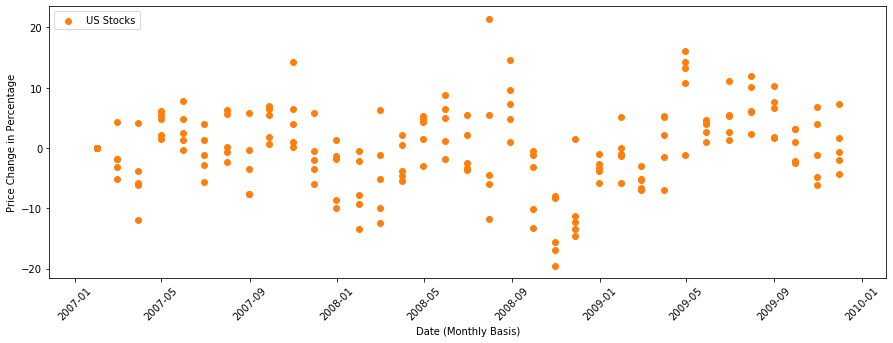

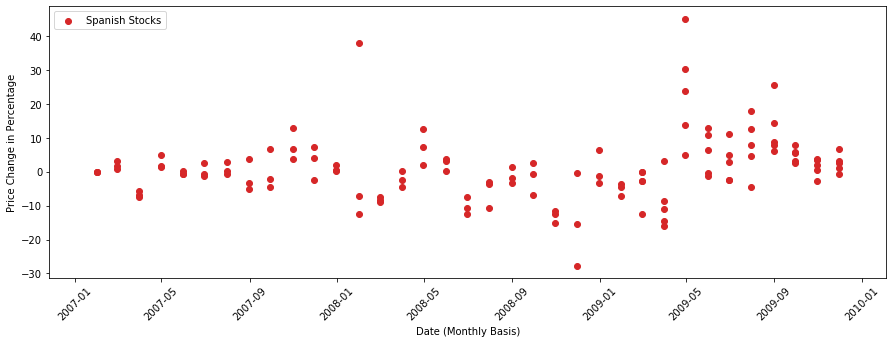

In [45]:
def recession_analysis(df):
    
    import matplotlib.pyplot as plt
    
    df = df.sort_index(level='date').reset_index()
    #df = df.drop(["symbol"], axis=1)
    df["avg_price"] = df.apply(avg_price, axis=1)
    
    df_US = df[df["market"] == "US"]
    df_US = df_US[(df_US["date"] >= "2007-01-31") & (df_US["date"] < "2009-12-31")]
    df_US = df_US.sort_index(level='date').reset_index()
    df_US = df_US.sort_values(by=['symbol', "date"])
    df_US['monthly_performance'] = df_US.groupby("symbol").avg_price.pct_change().fillna(0)
    df_US['monthly_performance'] = df_US['monthly_performance'] * 100
    #df_US["monthly_performance"].plot(rot=45)
    plt.figure(figsize=(15, 5))
    plt.scatter(df_US["date"],df_US["monthly_performance"], color='tab:orange', label="US Stocks")
    plt.xticks(rotation = 45)
    plt.ylabel("Price Change in Percentage")
    plt.xlabel("Date (Monthly Basis)")
    plt.legend(loc='upper left')
    
    df_Span = df[df["market"] == "Spanish"]
    df_Span = df_Span[(df_Span["date"] >= "2007-01-31") & (df_Span["date"] < "2009-12-31")]
    df_Span = df_Span.sort_index(level='date').reset_index()
    df_Span = df_Span.sort_values(by=['symbol', "date"])
    df_Span['monthly_performance'] = df_Span.groupby("symbol").avg_price.pct_change().fillna(0)
    df_Span['monthly_performance'] = df_Span['monthly_performance'] * 100
    #df_US["monthly_performance"].plot(rot=45)
    plt.figure(figsize=(15, 5))
    plt.scatter(df_Span["date"],df_Span["monthly_performance"], color='tab:red', label="Spanish Stocks")
    plt.xticks(rotation = 45)
    plt.ylabel("Price Change in Percentage")
    plt.xlabel("Date (Monthly Basis)")
    plt.legend(loc='upper left')
    
    print("The scatter graphs below display the monthly stock price change (for each stocks) in percentage. For US stocks, it seems that the change stays between -20% and 20% while \nthe Spanish stocks stay between -30% and 40%. Although it is somewhat difficult to eye-ball, it seeems that the price change between the years 2007-2009 dips below 0 quite a bit, especially during 2008. \nMore data points seem to lie below 0, although there are some outliers that have massive spikes.")
    
recession_analysis(merged)

### bollinger_band

This function takes in the merged data frame along with a single stock symbol (US or Spanish) from the data frame and crates Bollinger bands to illustrate the relative strength or momentum of a stock. We mask the merged dataset to create a new dataset that only has data regarding the stock symbol specified. We then create three Bollinger Bands in the form of columns to show the lower, middle, and upper bands of each stock at that specific month. A rolling window of 1 and 12 are used to indicate the passage of 1 and 12 months respectively. Then we plot the new columns, where the lower band shows the attractive value of the stock, the upper band shows the overpriced value of the stock, and the middle band shows the actual value of the stock.

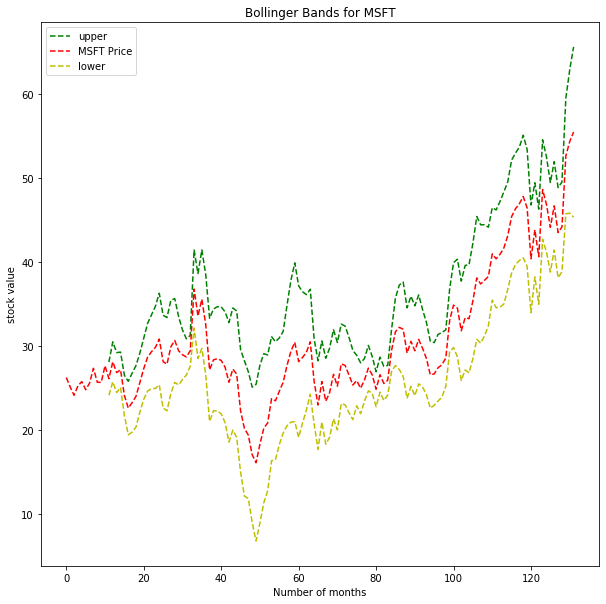


    There are three different Bollinger Bands:
   
    1. Middle Band= 1-month simple moving average (SMA)
    2. Upper Band= 1-month SMA+(12-month standard deviation of price x 2)
    3. Lower Band= 1-month SMA–(12-month standard deviation of price x 2)
   
    Bollinger Bands illustrate the relative strength or momentum of a stock.
    Bollinger Bands act as an envelope around the price of a stock.
   
    When the price of the stock is considered relatively low (attractive), it is near the lower band.
    If the stock is relatively high (overvalued), it’s near the upper band.

    


In [39]:
def bollinger_band(df, stock_symbol):
    
    import matplotlib.pyplot as plt
   
    # mask merged dataset to only look at rows with that specific stock
    df = df.sort_index(level='date').reset_index()
    df = df[df['symbol'] == stock_symbol]
    # make the index start from zero and increment by one
    df.reset_index(inplace=True)
   
    # create the three bands as new entries in the DataFrame.
    df['middle_band'] = df['close_price'].rolling(window=1).mean()
    df['upper_band'] = df['close_price'].rolling(window=1).mean() + df['close_price'].rolling(window=12).std()*2
    df['lower_band'] = df['close_price'].rolling(window=1).mean() - df['close_price'].rolling(window=12).std()*2
   
    plt.figure(figsize=(10,10))
    plt.plot(df['upper_band'], 'g--', label="upper")
    plt.plot(df['middle_band'], 'r--', label= stock_symbol + " Price")
    plt.plot(df['lower_band'], 'y--', label="lower")
    plt.title('Bollinger Bands for ' + stock_symbol)
    plt.xlabel('Number of months')
    plt.ylabel('stock value')
    plt.legend()
    plt.show()
   
    print('''
    There are three different Bollinger Bands:
   
    1. Middle Band= 1-month simple moving average (SMA)
    2. Upper Band= 1-month SMA+(12-month standard deviation of price x 2)
    3. Lower Band= 1-month SMA–(12-month standard deviation of price x 2)
   
    Bollinger Bands illustrate the relative strength or momentum of a stock.
    Bollinger Bands act as an envelope around the price of a stock.
   
    When the price of the stock is considered relatively low (attractive), it is near the lower band.
    If the stock is relatively high (overvalued), it’s near the upper band.

    '''
    )

bollinger_band(merged, 'MSFT')

### top_yearly_stock

This function takes in the merged dataframe that contains the data of both US and Spanish stocks. It then seperates them by the market and resamples it by the year in order to create a multi-level index of year and symbol. This makes it possible for us to create a new dataframe that has all the stocks' avergae open prices based on the year. The function creates two bar graphs as visualizations to show the performance of each stock each year from 2005-2015 within their own markets.


The graphs below display the average open price for each stocks across the entire 10 years long time period. Industria de Diseno Textil SA (ITX) and AMGEN (AMGN) seem to be the dominating stocks.


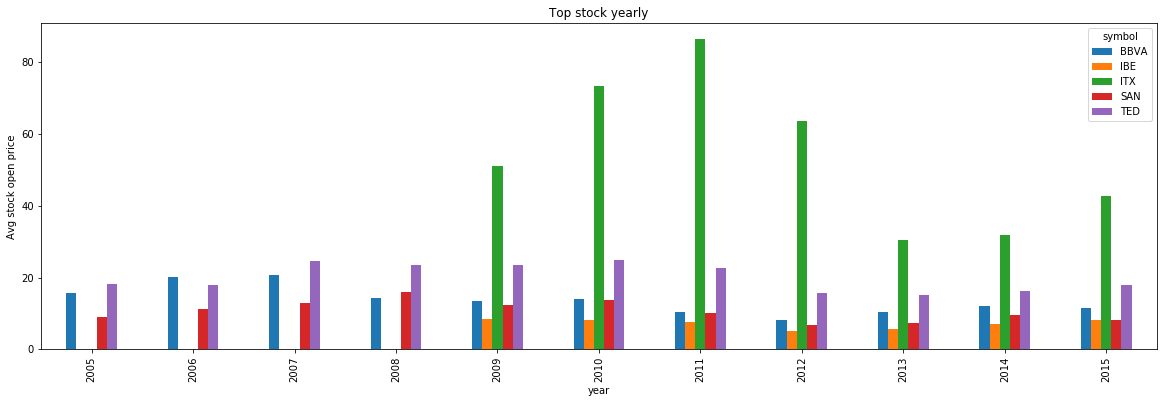

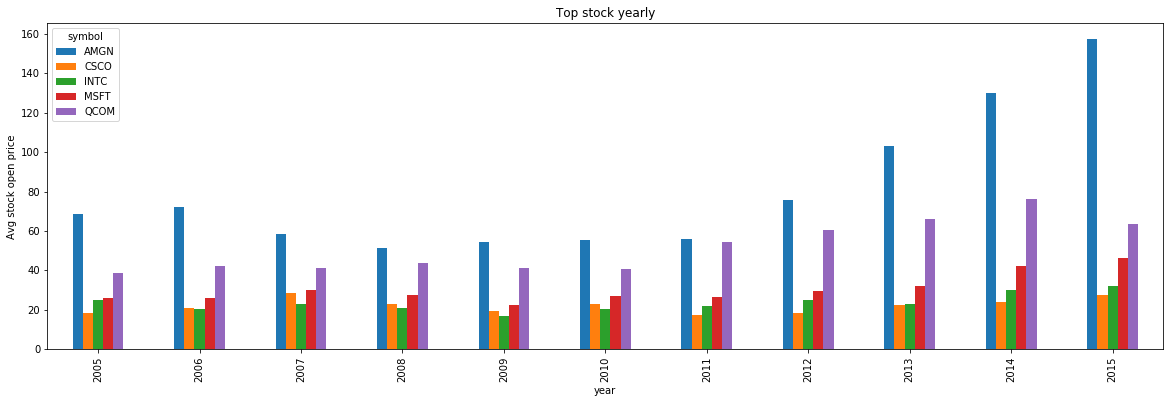

In [37]:
def top_yearly_stock(merged):  
    import matplotlib.pyplot as plt
    plt.rcParams['figure.figsize'] = (20,6) #make the charts larger for better visualization
    
    merged = merged.sort_index(level='date').reset_index()

    # stock prices for the spanish index (ibex 35)
    df_spain = merged[merged['market'] == 'Spanish']
    # group by the symbol of the stocks and resample the dates by year
    df_spain = df_spain.groupby("symbol").resample('A', on="date").mean().reset_index()
    # create a new 'year' column in order to use it in a multi-level index
    df_spain['year'] = pd.DatetimeIndex(df_spain['date']).year
    df_spain = df_spain.set_index(['year', 'symbol']).open_price
    # create the barchart
    df_spain.unstack().plot(kind='bar')
    plt.title("Top stock yearly")
    plt.ylabel("Avg stock open price")

    # stock prices for american index (nasdaq)
    df_usa = merged[merged['market'] == 'US']
    # group by the symbol of the stocks and resample the dates by year
    df_usa = df_usa.groupby("symbol").resample('A', on="date").mean().reset_index()
    # create a new 'year' column in order to use it in a multi-level index
    df_usa['year'] = pd.DatetimeIndex(df_usa['date']).year
    df_usa = df_usa.set_index(['year', 'symbol']).open_price
    # create the barchart
    df_usa.unstack().plot(kind='bar')
    plt.title("Top stock yearly")
    plt.ylabel("Avg stock open price")
    
    print("The graphs below display the average open price for each stocks across the entire 10 years long time period. Industria de Diseno Textil SA (ITX) and AMGEN (AMGN) seem to be the dominating stocks.")
   

top_yearly_stock(merged)

In [ ]:
def test_cases():
    
    test_fetched_data = get_monthly_data(["MSFT","INTC","CSCO","AMGN","QCOM"])
    test_df = create_sql_db(fetched_data)
    
    #test if get_monthly_data returns a dictionary
    assert type(test_fetched_data) == dict
    
    #test if returned dictionary's length is correct
    assert sum([len(v) for v in test_fetched_data.values()]) == 1285
    
    #test if create_sql_db returns a pandas dataframe
    assert type(test_df) == pd.DataFrame
    
    #test if returned dataframe's len is correct (after filtering out data using sql)
    assert len(test_df) == 660
    
    

if __name__ == "__main__":
    test_getmonthly_and_createsql()
    print("Everything passed")